# Prepare data for Clustering 
> Convert data types 

In [1]:
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from __future__ import print_function
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from datetime import timedelta

%matplotlib inline 

# download chs.pkl
chs = pd.read_pickle('chs.pkl')
ParkDurationMins = (chs.EndDateTime - chs.StartDateTime) / timedelta(minutes=1)
chs['ParkDurationMins'] = ParkDurationMins

# reset index to sequential numbers
chs = chs.reset_index() 

chs['Year'] = chs.StartDateTime.dt.year
chs['Month'] = chs.StartDateTime.dt.month
chs['Day'] = chs.StartDateTime.dt.day
chs['Hour'] = chs.StartDateTime.dt.hour

# make weekend label
def convert_weekend(r):
    if r.dayofweek == 5 or r.dayofweek == 6:
        return 1
    else:
        return 0
    
chs['Weekend'] = chs['StartDateTime'].apply(convert_weekend)

#  make type label
def convert_type(t):
    if t == 'Slow':
        return 0
    elif t == 'Fast':
        return 1
    else:
        return 2
chs['Type'] = chs['Type'].apply(convert_type)    
    
# drop rows where ParkDurationMins <0 
chs = chs[chs.ParkDurationMins > 0]

# correct park duration to be at least equal to charge duration
charge_values = chs.ChargeDurationMins[chs.ChargeDurationMins > chs.ParkDurationMins].values

chs.ParkDurationMins[chs.ChargeDurationMins > chs.ParkDurationMins] = charge_values

# save a copy
chs_original = chs.copy()

In [2]:
chs.shape

(18773, 21)

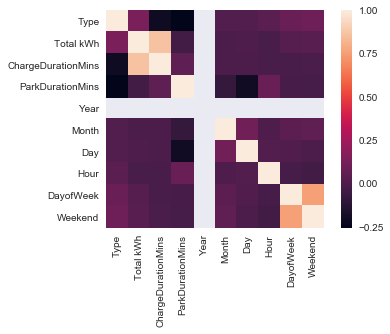

In [3]:
# Correlation among selected features
chs1 = chs[['Type','Total kWh','ChargeDurationMins','ParkDurationMins','Year','Month','Day'
            ,'Hour','DayofWeek','Weekend']]
cor = chs1.corr() #linear rescaling is unnecessary
sns.heatmap(cor, square = True)
# No significant insights from the correlation map

## Data transformation
> 
- rescale: MinMaxScaler
- standardize: StandardScaler
- normalize: Normalizer
- binarize: Binarizer

> Question:
- Will different transformation methods affect clustering results?

In [4]:
chs.columns

Index(['Charging event', 'CP ID', 'Total kWh', 'StartDateTime', 'EndDateTime',
       'User ID', 'Connector', 'Type', 'Latitude', 'Longitude',
       'Location Name', 'DayofWeek', 'DayofWeekName', 'StartHour',
       'ChargeDurationMins', 'ParkDurationMins', 'Year', 'Month', 'Day',
       'Hour', 'Weekend'],
      dtype='object')

In [5]:
all_features_chs = ['Charging event','CP ID','Total kWh'
                       ,'StartDateTime','EndDateTime','Site'
                    ,'User ID','Connector','Type','Latitude'
                    ,'Longitude','Location Name','DayofWeek'
                    ,'DayofWeekName','StartHour','ChargeDurationMins'
                    ,'ParkDurationMins','Year','Month','Day','Hour'
                    ,'Weekend'
                      ]
# separating out the features
# "feature engineering" select&train significant features  
# did not include park duration, since it is ridiculously long, apparently faulty in many records
features = ['Type','Total kWh','ChargeDurationMins'#,'ParkDurationMins'#,'Year','Month','Day'
            ,'Hour','DayofWeek','Weekend']
# convert data types
X = chs.loc[:,features].astype('float64').values
# separating out unique ID
uniqueID = ['Charging event','CP ID','Connector']
y = chs.loc[:,uniqueID].values

# Rescale data: into range between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
print(X.shape)

# # Standardize data: transform attributes with standard Gaussian
# # distribution with mean 0 and std 1
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Normalize Data
# from sklearn.preprocessing import Normalizer
# scaler = Normalizer()
# X = scaler.fit_transform(X)

# # Binarize Data
# from sklearn.preprocessing import Binarizer
# scale = Binarizer(threshold=0.0)
# X = binarizer.fit_transform(X)


(18773, 6)


## *PCA for dimensionality reduction and data visualization
> Question: 
- PCA before clustering or after?
- PCA or Factor Analysis
- How to interpret the results?


In [6]:
# PCA analysis
pca = PCA().fit(X)
print('Explained variance by component: %s' %pca.explained_variance_ratio_)
pca = pd.DataFrame(pca.components_, columns=features)
print(pca)

# Factor Analysis
factor= FactorAnalysis().fit(X)
fa = pd.DataFrame(factor.components_, columns=features)
print(fa)

pca = PCA(n_components=2)
principleComponents = pca.fit_transform(X)
# principalDF = pd.DataFrame(data=principleComponents,
#                            columns = ['principle component 1',
#                                       'principle component 2'])
# # visualise 2D projection
# fig = plt.figure(figsize=(15,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# clusters = ['0','1','2']
# colors = ['r','g','b']
# # for cluster, color in zip(clusters,colors):
# #     indicesToKeep = principalDF['Cluster'] == cluster
# #     ax.scatter(principalDF.loc[indicesToKeep,'principal component 1']
# #               , principalDF.loc[indicesToKeep,'principal component 2']
# #               , c=color
# #               , s=50)
# # ax.legend(clusters)
# # ax.grid

# Append principle components (the last 2 columns of X_w_PCA) to X array
X_w_PCA = np.append(X, principleComponents, axis=1)

Explained variance by component: [4.99436276e-01 3.37351481e-01 1.03211038e-01 5.97676991e-02
 2.24414907e-04 9.09198448e-06]
       Type  Total kWh  ChargeDurationMins      Hour  DayofWeek   Weekend
0  0.264179   0.001057           -0.000804 -0.011176   0.534425  0.802790
1 -0.963843  -0.002380            0.003636 -0.038818   0.148273  0.217937
2  0.034451   0.000649            0.000016 -0.999089  -0.023173 -0.009820
3  0.003037  -0.000422           -0.000373 -0.013734   0.831786 -0.554918
4  0.000506   0.751071            0.660220  0.000516   0.000248 -0.000653
5  0.004505  -0.660215            0.751063 -0.000264   0.000049  0.000103
       Type  Total kWh  ChargeDurationMins      Hour  DayofWeek   Weekend
0 -0.014448   0.005478            0.004937 -0.006312   0.035867  0.051414
1 -0.071974   0.000593            0.001034  0.006937  -0.193449 -0.264179
2  0.086279   0.000410           -0.000181  0.033306  -0.008022 -0.009985
3  0.000000   0.000000           -0.000000 -0.000000  -0.000

## k-means from scikit-learn
> Questions:
- Is k-means a good algorithm here?
- How to validate clustering analysis results?
    - Design an error score function?
    - 2D/3D visualization through dimensionality reduction?
    - Other clustering methods?
- Actions after clustering?

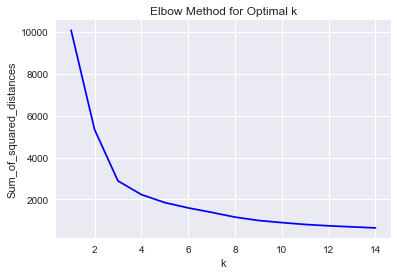

In [8]:
# # Determine the optimal number of clusters k
# # https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

# determine number of clusters 
def elbowMethod(X, range_n_clusters = range(1,15)):    
    sum_of_squared_distances = []
    for k in range_n_clusters:
        kmeans = KMeans(n_clusters=k)
        kmeans = kmeans.fit(X)
        sum_of_squared_distances.append(kmeans.inertia_)
    # plot
    plt.plot(range_n_clusters, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method for Optimal k')
    return plt.show()

elbowMethod(X)

fig = plt.gcf()
plt.tight_layout()
fig.savefig('Elbow_method.png')
# # Number of Clusters: critical number is 3, 4, 5

## Execute K Means and find the actual cluster centeroids

In [9]:
# If rescale X to range of 0 and 1, k=4. The composition of three types of chargers is slow (36%), fast (7%) and
# rapid (57%). Since there are not enough fast chargers , they are not 
# reflected in the clusters.

# Euclidean Distance Calculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

def km_actual_clust(X, df_X, features, nclust=2):
    model = KMeans(n_clusters=nclust)
    model = model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    km_clusters = pd.DataFrame(clust_labels)
    df_X.insert((df_X.shape[1]), 'km_clusters', km_clusters)
    
    # find the actual cluster centroids, is the nearest datapoint to kmeans centroids
    km_centroids = scaler.inverse_transform(cent) #3X6 matrix
    actual_centroids = np.zeros(km_centroids.shape)    
    for i in range(0, nclust):
        cluster_i = np.array(df_X[df_X.km_clusters==i].drop(['km_clusters'],axis=1))
        distances = dist(cluster_i, km_centroids[i])
        actual_centroids[i] = cluster_i[np.argmin(distances)] 
    df_actual_centroids = pd.DataFrame(data = actual_centroids, columns = features)
    
    return print(df_actual_centroids)

chs = chs[features]
km_actual_clust(X, chs, features, 3)

   Type  Total kWh  ChargeDurationMins  Hour  DayofWeek  Weekend
0   1.0      9.713           26.490000  13.0        5.0      1.0
1   2.0     10.908           13.089600  13.0        2.0      0.0
2   0.0      5.648           48.411429  13.0        1.0      0.0


### Clustering analysis validation

> 
- try sklearn.metrics.silhouette_score, 
- or other metrics such as Normalized Mutual Information and Adjusted Rand Score.
- seaborn facet plot
- other visualization: sklearn.manifold.TSNE for high-dimensional data
- try hierarchical clustering https://www.kaggle.com/kernels/notebooks/new?forkParentScriptVersionId=2148091&userName=dryuki
- consider soft clustering, there might be overlapping 
- kaggle learn: time series modelling 

In [14]:
"""
    reduce sample size for computing silhouette score
    ---------------
    parameters:
    ---------------
    X_w_PCA: X with pca components attached 
    X_w_PCA_ds: down sized 
"""
mask = np.random.choice([False, True], len(X_w_PCA), p=[0, 1])
X_w_PCA_ds = X_w_PCA[mask]
X_ds = X_w_PCA_ds[:,:-2]
X_PCA = X_w_PCA_ds[:,[-2,-1]]

In [18]:
X_ds.shape

(18773, 6)

For n_clusters = 3 The average silhouette_score is : 0.5215196128625036
For n_clusters = 4 The average silhouette_score is : 0.5317456547880447
For n_clusters = 5 The average silhouette_score is : 0.435359531244165


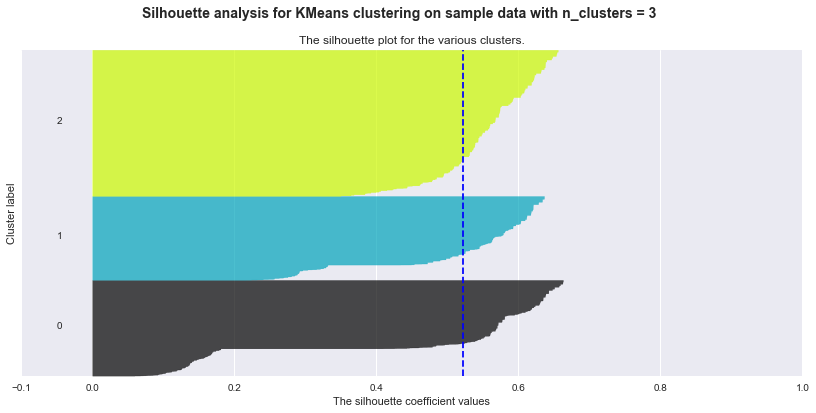

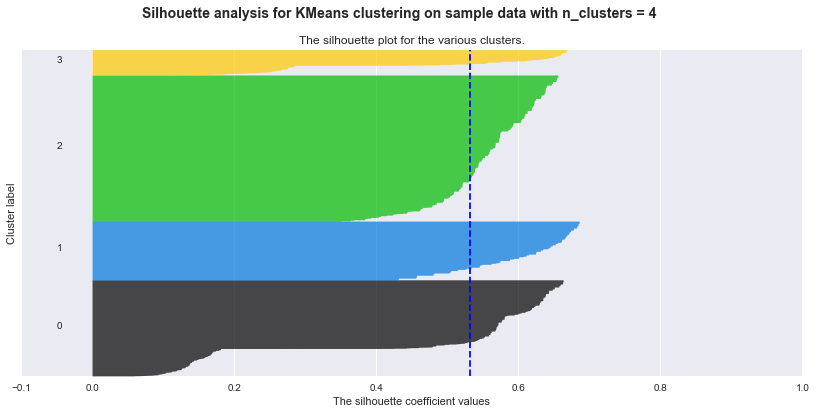

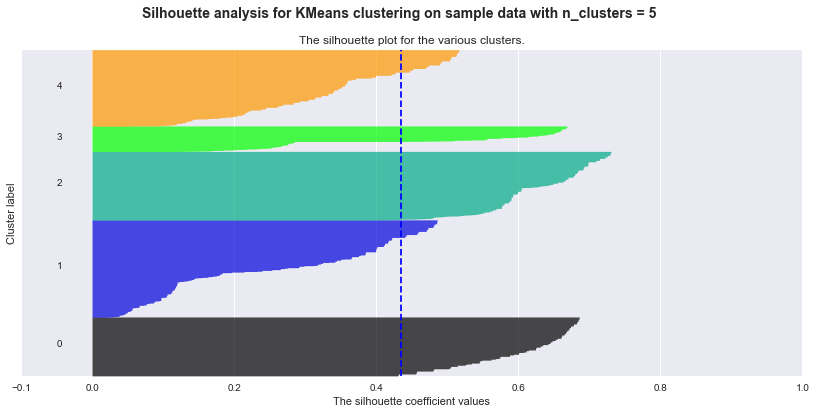

In [19]:
# compute silhouette_score

def show_silhouette_score(range_n_clusters, X):
    
    for n_clusters in range_n_clusters:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(14,6)
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)  
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        y_lower = 10
        
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor = color, edgecolor = color, alpha = 0.7) 
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10 # 10 for the 0 samples        
            
        ax.set_title('The silhouette plot for the various clusters.')
        ax.set_xlabel('The silhouette coefficient values')
        ax.set_ylabel('Cluster label')
        ax.axvline(x = silhouette_avg, color = 'blue', linestyle = '--')    
        ax.set_yticks([]) # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])    
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')    
    return plt.show()

range_n_clusters = [3, 4, 5]

show_silhouette_score(range_n_clusters, X_ds)

fig = plt.gcf()
plt.tight_layout()
fig.savefig('silhouette_score.png')

### Try hierarchical clustering, how to compare this results with that of k means?

> same when k =3


In [20]:
# hierarchical clustering/agglomerative clustering
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity='euclidean',linkage='ward')
    clust_labels = model.fit_predict(X)
    return(clust_labels)

clust_labels3 = doAgglomerative(X, 3)
hrch_clusters = pd.DataFrame(clust_labels3)
chs.insert((chs.shape[1]), 'hrch_clusters', hrch_clusters)

**Cluster among rapid, fast, slow, separately**

In [21]:
# cluster among rapid, fast, slow, separately
X_r = chs.loc[chs['Type']==2, features].astype('float64').values
X_r = scaler.fit_transform(X_r)

X_f = chs.loc[chs['Type']==1, features].astype('float64').values
X_f = scaler.fit_transform(X_f)

X_s = chs.loc[chs['Type']==0, features].astype('float64').values
X_s = scaler.fit_transform(X_s)

print(X_r.shape, X_f.shape, X_s.shape)

(11799, 6) (2151, 6) (4823, 6)


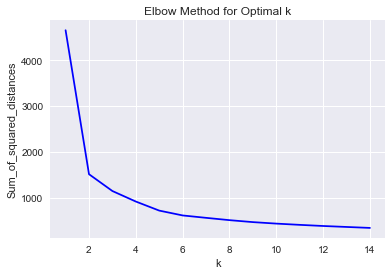

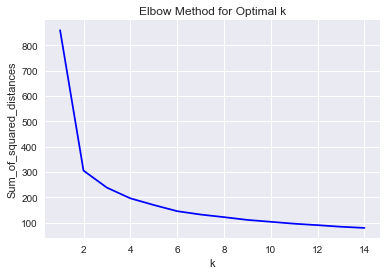

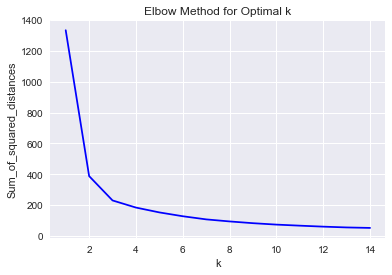

In [22]:
elbowMethod(X_r)
elbowMethod(X_f)
elbowMethod(X_s)

For n_clusters = 2 The average silhouette_score is : 0.6278702350505646
For n_clusters = 3 The average silhouette_score is : 0.4057214459725335


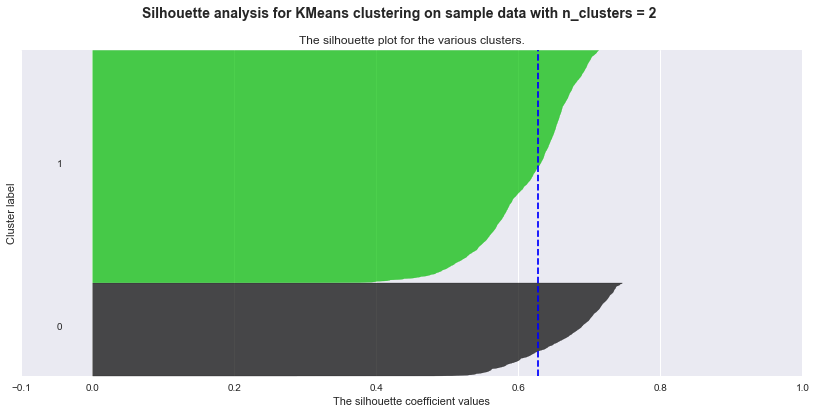

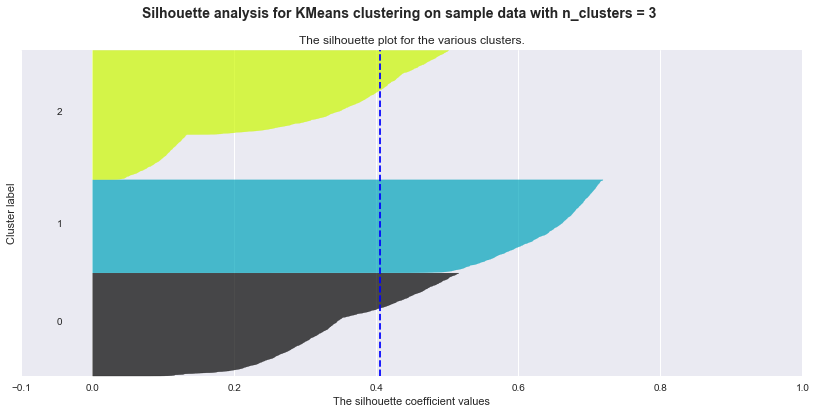

In [23]:
range_n_clusters_r = [2, 3]
range_n_clusters_f = [2, 3]
range_n_clusters_s = [2, 3]
show_silhouette_score(range_n_clusters_r, X_r) # k = 2

In [ ]:
show_silhouette_score(range_n_clusters_f, X_f) # k = 2

In [ ]:
show_silhouette_score(range_n_clusters_s, X_s) # k = 2

In [ ]:
# df_chs = df_chs[features]
# km_actual_clust(X, df_chs, features, 3)
chs_r = chs.loc[chs['Type']==2, features]
chs_f = chs.loc[chs['Type']==1, features]
chs_s = chs.loc[chs['Type']==0, features]

print (km_actual_clust(X_r, chs_r, features))
print (km_actual_clust(X_f, chs_f, features))
print (km_actual_clust(X_s, chs_s, features))

# does not make much sense, take the results from clustering on all samples

In [ ]:
# soft clustering

In [ ]:
# visualize critical datapoints